In [6]:
from pickle import dump 
import re
import numpy as np
from unicodedata import normalize
import string

<h3>Read data</h3>
<p>Data from http://www.manythings.org/, German words and their translations</p>

In [17]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [18]:
doc = load_doc('data/deu-eng/deu.txt')

In [19]:
doc[:20]

'Hi.\tHallo!\nHi.\tGrüß '

<h3>Cleaning the data</h3>

In [20]:
def to_pairs(doc):
    lines = doc.split('\n')
    pairs = [x.split('\t') for x in lines]
    return pairs

In [21]:
pairs = to_pairs(doc)
pairs[:5]

[['Hi.', 'Hallo!'],
 ['Hi.', 'Grüß Gott!'],
 ['Run!', 'Lauf!'],
 ['Fire!', 'Feuer!'],
 ['Help!', 'Hilfe!']]


- Remove all non-printable characters.
- Remove all punctuation characters.
- Normalize all Unicode characters to ASCII (e.g. Latin characters).
- Normalize the case to lowercase.
- Remove any remaining tokens that are not alphabetic.


In [26]:
# clean a list of lines
def clean_pairs(lines):
    cleaned = list()
    # prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for pair in lines:
        clean_pair = list()
        for line in pair:
            # normalize unicode characters
            line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode('UTF-8')
            # tokenize on white space
            line = line.split()
            # convert to lowercase
            line = [word.lower() for word in line]
            # remove punctuation from each token
            line = [word.translate(table) for word in line]
            # remove non-printable chars form each token
            line = [re_print.sub('', w) for w in line]
            # remove tokens with numbers in them
            line = [word for word in line if word.isalpha()]
            # store as string
            clean_pair.append(' '.join(line))
        cleaned.append(clean_pair)
    return np.array(cleaned)

The unicodedata module offers a .normalize() function, you want to normalize to the NFC form. NFC, or 'Normal Form Composed' returns composed characters, NFD, 'Normal Form Decomposed' gives you decomposed, combined characters.

In [27]:
cleaned_pairs = clean_pairs(pairs)
cleaned_pairs[:5]

array([list(['hi', 'hallo']), list(['hi', 'gru gott']),
       list(['run', 'lauf']), list(['fire', 'feuer']),
       list(['help', 'hilfe'])], dtype=object)

<h3>Save the cleansed data</h3>

In [32]:
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)

In [38]:
save_clean_data(cleaned_pairs, "data/deu-eng/cleansed_deu.pkl")

Saved: data/deu-eng/cleansed_deu.pkl


<h3>Loading the processed data</h3>

In [1]:
from pickle import load
from numpy.random import rand
from numpy.random import shuffle

In [2]:
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))

In [3]:
raw_dataset = load_clean_sentences('data/deu-eng/cleansed_deu.pkl')

In [4]:
raw_dataset[:5]

array([list(['hi', 'hallo']), list(['hi', 'gru gott']),
       list(['run', 'lauf']), list(['fire', 'feuer']),
       list(['help', 'hilfe'])], dtype=object)

In [5]:
len(raw_dataset)

169814

<h3>Test Train Split</h3>

In [7]:
n_sentences = 10000
dataset = raw_dataset[:n_sentences]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:9000], dataset[9000:]

In [8]:
train[:5], len(train)

(array([list(['i like to dream', 'ich traume gern']),
        list(['i look like tom', 'ich sehe wie tom aus']),
        list(['boys are stupid', 'jungs sind doof']),
        list(['its been tried', 'es ist versucht worden']),
        list(['tom is safe', 'tom ist in sicherheit'])], dtype=object), 9000)

In [9]:
test[:5], len(test)

(array([list(['im not home', 'ich bin nicht zuhause']),
        list(['heres the bill', 'hier ist die rechnung']),
        list(['how old are you', 'wie alt bist du']),
        list(['id like a fork', 'ich hatte gerne eine gabel']),
        list(['toms finished', 'tom ist fix und fertig'])], dtype=object),
 1000)

<h3>Tokenize</h3>

Just get the english datset

In [10]:
english_lines = [x[0] for x in dataset]
english_lines[:4]

['i like to dream', 'i look like tom', 'boys are stupid', 'its been tried']

In [11]:
def max_length(lines):
    return max(len(line.split()) for line in lines)

In [12]:
eng_length = max_length(english_lines)
eng_length

5

In [13]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [14]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [15]:
eng_tokenizer = create_tokenizer(english_lines)

In [16]:
from pandas import DataFrame

In [17]:
type(eng_tokenizer.word_index)

dict

In [18]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_vocab_size

2315

In [19]:
eng_token_mapping = DataFrame.from_dict(eng_tokenizer.word_index, orient = 'index')

In [20]:
eng_token_mapping[:5]

,0
tom,1
i,2
it,3
is,4
you,5


This is how the keras preprocessing tokenizes the english text, now we do the same for german texts.

In [21]:
de_lines = [x[1] for x in dataset]
de_tokenizer = create_tokenizer(de_lines)
de_token_mapping = DataFrame.from_dict(de_tokenizer.word_index, orient = 'index')
de_token_mapping[:5]

,0
ich,1
tom,2
ist,3
sie,4
es,5


In [22]:
de_length = max_length(de_lines)
de_length

10

In [23]:
de_vocab_size = len(de_tokenizer.word_index) + 1
de_vocab_size

3686

We have tokenized the entire dataset, now we need to apply this to the training and testing dataset using the tokenizer created. We need to encode each sequence to max length to be used as a word embedding. Keras pad sequence helps to pad all sequences into similar length. 'post' padding option allows us to add 0's after each sequence to complete the max length.

In [24]:
from keras.preprocessing.sequence import pad_sequences 

In [25]:
def encode_seq(tokenizer, length, lines):
    # integer encode sequences
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X

In [26]:
trainY = encode_seq(de_tokenizer, de_length, [x[1] for x in train])
trainX = encode_seq(eng_tokenizer, eng_length, [x[0] for x in train])

testY = encode_seq(de_tokenizer, de_length, [x[1] for x in test])
testX = encode_seq(eng_tokenizer, eng_length, [x[0] for x in test])

In [27]:
trainX[:5]

array([[  2,  33,  15, 386,   0],
       [  2,  63,  33,   1,   0],
       [848,  17, 218,   0,   0],
       [ 10, 476, 321,   0,   0],
       [  1,   4, 246,   0,   0]], dtype=int32)

The final layer would be a probablity distribution of each word appearing in the sentence and hence has to be one hot encoded layer.

In [28]:
trainX = trainX[:1000]
testX = testX[:100]

In [29]:
from keras.utils import to_categorical
#Converts a class vector (integers) to binary class matrix.

In [30]:
def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = np.array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

In [31]:
trainY = encode_output(trainY[:1000], de_vocab_size)

In [32]:
trainY[:5].shape

(5, 10, 3686)

In [33]:
trainY[:1]

array([[[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]])

In [34]:
testY = encode_output(testY[:100], de_vocab_size)

<h3>Model</h3>

In [35]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

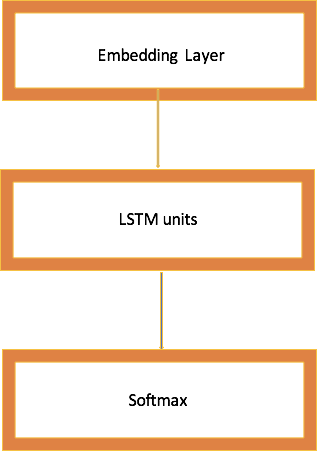

In [36]:
def def_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units)) #encoder
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model

In [57]:
model = def_model(eng_vocab_size, de_vocab_size, eng_length, de_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy') #use adam to train the model

In [58]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 5, 256)            592640    
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 10, 256)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 256)           525312    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 3686)          947302    
Total params: 2,590,566
Trainable params: 2,590,566
Non-trainable params: 0
_________________________________________________________________
None


We must connect the encoder to the decoder, and they do not fit.

That is, the encoder will produce a 2-dimensional matrix of outputs, where the length is defined by the number of memory cells in the layer. The decoder is an LSTM layer that expects a 3D input of [samples, time steps, features] in order to produce a decoded sequence of some different length defined by the problem.

If you try to force these pieces together, you get an error indicating that the output of the decoder is 2D and 3D input to the decoder is required.

We can solve this using a <b>RepeatVector layer</b>. This layer simply repeats the provided 2D input multiple times to create a 3D output.

<h3>Save the model</h3>

In [59]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

<h3>Train the model</h3>

In [60]:
model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

Train on 1000 samples, validate on 100 samples
Epoch 1/30
 - 21s - loss: 7.4668 - val_loss: 3.9479

Epoch 00001: val_loss improved from inf to 3.94786, saving model to model.h5
Epoch 2/30
 - 2s - loss: 2.9538 - val_loss: 2.9843

Epoch 00002: val_loss improved from 3.94786 to 2.98433, saving model to model.h5
Epoch 3/30
 - 2s - loss: 2.6483 - val_loss: 2.8775

Epoch 00003: val_loss improved from 2.98433 to 2.87746, saving model to model.h5
Epoch 4/30
 - 2s - loss: 2.4780 - val_loss: 2.7522

Epoch 00004: val_loss improved from 2.87746 to 2.75224, saving model to model.h5
Epoch 5/30
 - 2s - loss: 2.3264 - val_loss: 2.6526

Epoch 00005: val_loss improved from 2.75224 to 2.65262, saving model to model.h5
Epoch 6/30
 - 2s - loss: 2.2359 - val_loss: 2.5603

Epoch 00006: val_loss improved from 2.65262 to 2.56027, saving model to model.h5
Epoch 7/30
 - 2s - loss: 2.1370 - val_loss: 2.5140

Epoch 00007: val_loss improved from 2.56027 to 2.51402, saving model to model.h5
Epoch 8/30
 - 2s - loss: 

<h3>Loading the saved model</h3>

In [62]:
from keras.models import load_model

In [63]:
model = load_model('model.h5')

In [65]:
translation = model.predict(testX, verbose=0)

In [68]:
translation[0] #probablity distribution of first sequence

array([[3.42604762e-04, 3.43670785e-01, 1.20422654e-01, ...,
        5.01693989e-07, 2.86902093e-07, 4.53218547e-07],
       [7.61445379e-04, 3.56775448e-02, 3.07792313e-02, ...,
        2.15923649e-07, 8.81704665e-08, 1.52009363e-07],
       [5.00156265e-03, 4.55194898e-03, 1.85940862e-02, ...,
        2.28333334e-07, 8.08500076e-08, 1.53478595e-07],
       ...,
       [9.91239607e-01, 7.55340295e-07, 2.28405406e-04, ...,
        3.51157159e-10, 1.03764046e-10, 1.41254689e-10],
       [9.91378188e-01, 7.37682228e-07, 2.24740521e-04, ...,
        3.43785223e-10, 1.01556055e-10, 1.38058412e-10],
       [9.91397500e-01, 7.35363869e-07, 2.24252915e-04, ...,
        3.42727347e-10, 1.01241626e-10, 1.37596587e-10]], dtype=float32)

In [69]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

We can perform this mapping for each integer in the translation and return the result as a string of words.

In [74]:
def predict_sequence(model, tokenizer, source):
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

This function will select the word with maximum probablity and then append to get the predicted sentence

In [82]:
predictions = predict_sequence(model, de_tokenizer, testX)

In [83]:
predictions[:13]

'ich ist nicht'

<h3>Evaluation</h3>

Evaluation for machine translation is mainle done using a score called BLEU https://www.aclweb.org/anthology/P02-1040.pdf. For this we need to import corpus_bleu from nltk.

In [87]:
from nltk.translate.bleu_score import corpus_bleu

In [94]:
def evaluate_model(model, tokenizer, sources, raw_dataset):
    actual, predicted = list(), list()
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_sequence(model, tokenizer, source)
        raw_target = [x[1] for x in dataset][i]
        raw_src = [x[0] for x in dataset][i]
        if i < 5:
            print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
        actual.append(raw_target.split())
        predicted.append(translation.split())
    # calculate BLEU score
#     print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
#     print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
#     print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
#     print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [95]:
evaluate_model(model, de_tokenizer, testX, test)

src=[i like to dream], target=[ich traume gern], predicted=[ich ist nicht nicht]
src=[i look like tom], target=[ich sehe wie tom aus], predicted=[ich ist nicht]
src=[boys are stupid], target=[jungs sind doof], predicted=[ich ist nicht]
src=[its been tried], target=[es ist versucht worden], predicted=[tom ist]
src=[tom is safe], target=[tom ist in sicherheit], predicted=[tom ist]
src=[i hurried home], target=[ich eilte nach hause], predicted=[tom ist nicht]
src=[im miserable], target=[ich bin unglucklich], predicted=[ich ist nicht]
src=[you are crazy], target=[du bist verruckt], predicted=[tom sie]
src=[tom looks well], target=[tom sieht gut aus], predicted=[ich ist nicht]
src=[keep it up], target=[nicht nachlassen], predicted=[ich ist nicht]


In [98]:
print(testX[:5])

[[   7   28   49    0    0]
 [ 368   18 1064    0    0]
 [  51  197   17    5    0]
 [ 265   33    6 2235    0]
 [  38  802    0    0    0]]


In [99]:
print(test[:5])

[list(['im not home', 'ich bin nicht zuhause'])
 list(['heres the bill', 'hier ist die rechnung'])
 list(['how old are you', 'wie alt bist du'])
 list(['id like a fork', 'ich hatte gerne eine gabel'])
 list(['toms finished', 'tom ist fix und fertig'])]
